In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
pwd

'/Users/bstanisl/Documents/repos/PVade/examples'

In [3]:
fname = '../output/empty2d/solution/solution_fluid.h5'

In [ ]:
# Open the file (read-only)
with h5py.File(fname, "r") as f:
    # Explore the structure
    print("Top-level keys:", list(f.keys()))

    # print(f.visit(print))

    # Recursively print structure and types
    # def show_structure(name, obj):
    #     print(f"{name} -> {type(obj)}")

    # f.visititems(show_structure)

    # Access a dataset
    data = f["Function/velocity /0"][:]
    print(data.shape, data.dtype)

Top-level keys: ['Function', 'Mesh']
Function -> <class 'h5py._hl.group.Group'>
Function/f -> <class 'h5py._hl.group.Group'>
Function/f/0 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_02 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_040000000000000001 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_059999999999999998 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_080000000000000002 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_10000000000000001 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_12 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_14000000000000001 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_16 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_17999999999999999 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_20000000000000001 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_22 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_23999999999999999 -> <class 'h5py._hl.dataset.Dataset'>
Function/f/0_26000000000000001 -> <class 'h5py._hl.da

In [5]:
with h5py.File(fname, "r") as f:
    # Mesh coordinates  ===============
    coords = f["Mesh/fluid_mesh.xdmf/geometry"][:]
    print("Coords shape:", coords.shape)  # Should be (538, 3) or (538, 2)

    # Velocity ===============
    velocity_group = f["Function/velocity "]

    # Sort dataset keys numerically
    keys = sorted(velocity_group.keys(), key=lambda k: float(k.replace("_", ".")))

    # Load all time steps into list
    data_list = [velocity_group[k][:] for k in keys]
    data_array = np.stack(data_list)  # Shape: (n_timesteps, n_points, 3)

    # Temperature ===============
    temp_group = f["Function/temperature "]

    # Sort dataset keys numerically
    keys2 = sorted(velocity_group.keys(), key=lambda k: float(k.replace("_", ".")))

    # Load all time steps into list
    data_list2 = [temp_group[k][:] for k in keys2]
    temp_data_array = np.stack(data_list2)  # Shape: (n_timesteps, n_points, 3)


print("Combined velocity shape:", data_array.shape)  # e.g. (100, 5000, 3)
print("Combined temperature shape:", temp_data_array.shape)  # e.g. (100, 5000, 3)

Coords shape: (538, 2)
Combined velocity shape: (251, 538, 3)
Combined temperature shape: (251, 538, 1)


In [6]:
# Interpolate to regular grid
data = {}

nt, npoints, ncomp = data_array.shape

nx = 240 #120
ny = 40 #20

# Create regular grid to interpolate onto
xi = np.linspace(coords[:, 0].min(), coords[:, 0].max(), nx)
yi = np.linspace(coords[:, 1].min(), coords[:, 1].max(), ny)
X, Y = np.meshgrid(xi, yi, indexing='ij')

data['u'] = np.empty((nt, nx, ny))
data['v'] = np.empty((nt, nx, ny))
data['T'] = np.empty((nt, nx, ny))

# Interpolate
for t in range(nt):
    data['u'][t, :, :] = griddata(coords, data_array[t, :, 0], (X, Y), method='linear')
    data['v'][t, :, :] = griddata(coords, data_array[t, :, 1], (X, Y), method='linear')
    data['T'][t, :, :] = griddata(coords, temp_data_array[t, :, 0], (X, Y), method='linear')


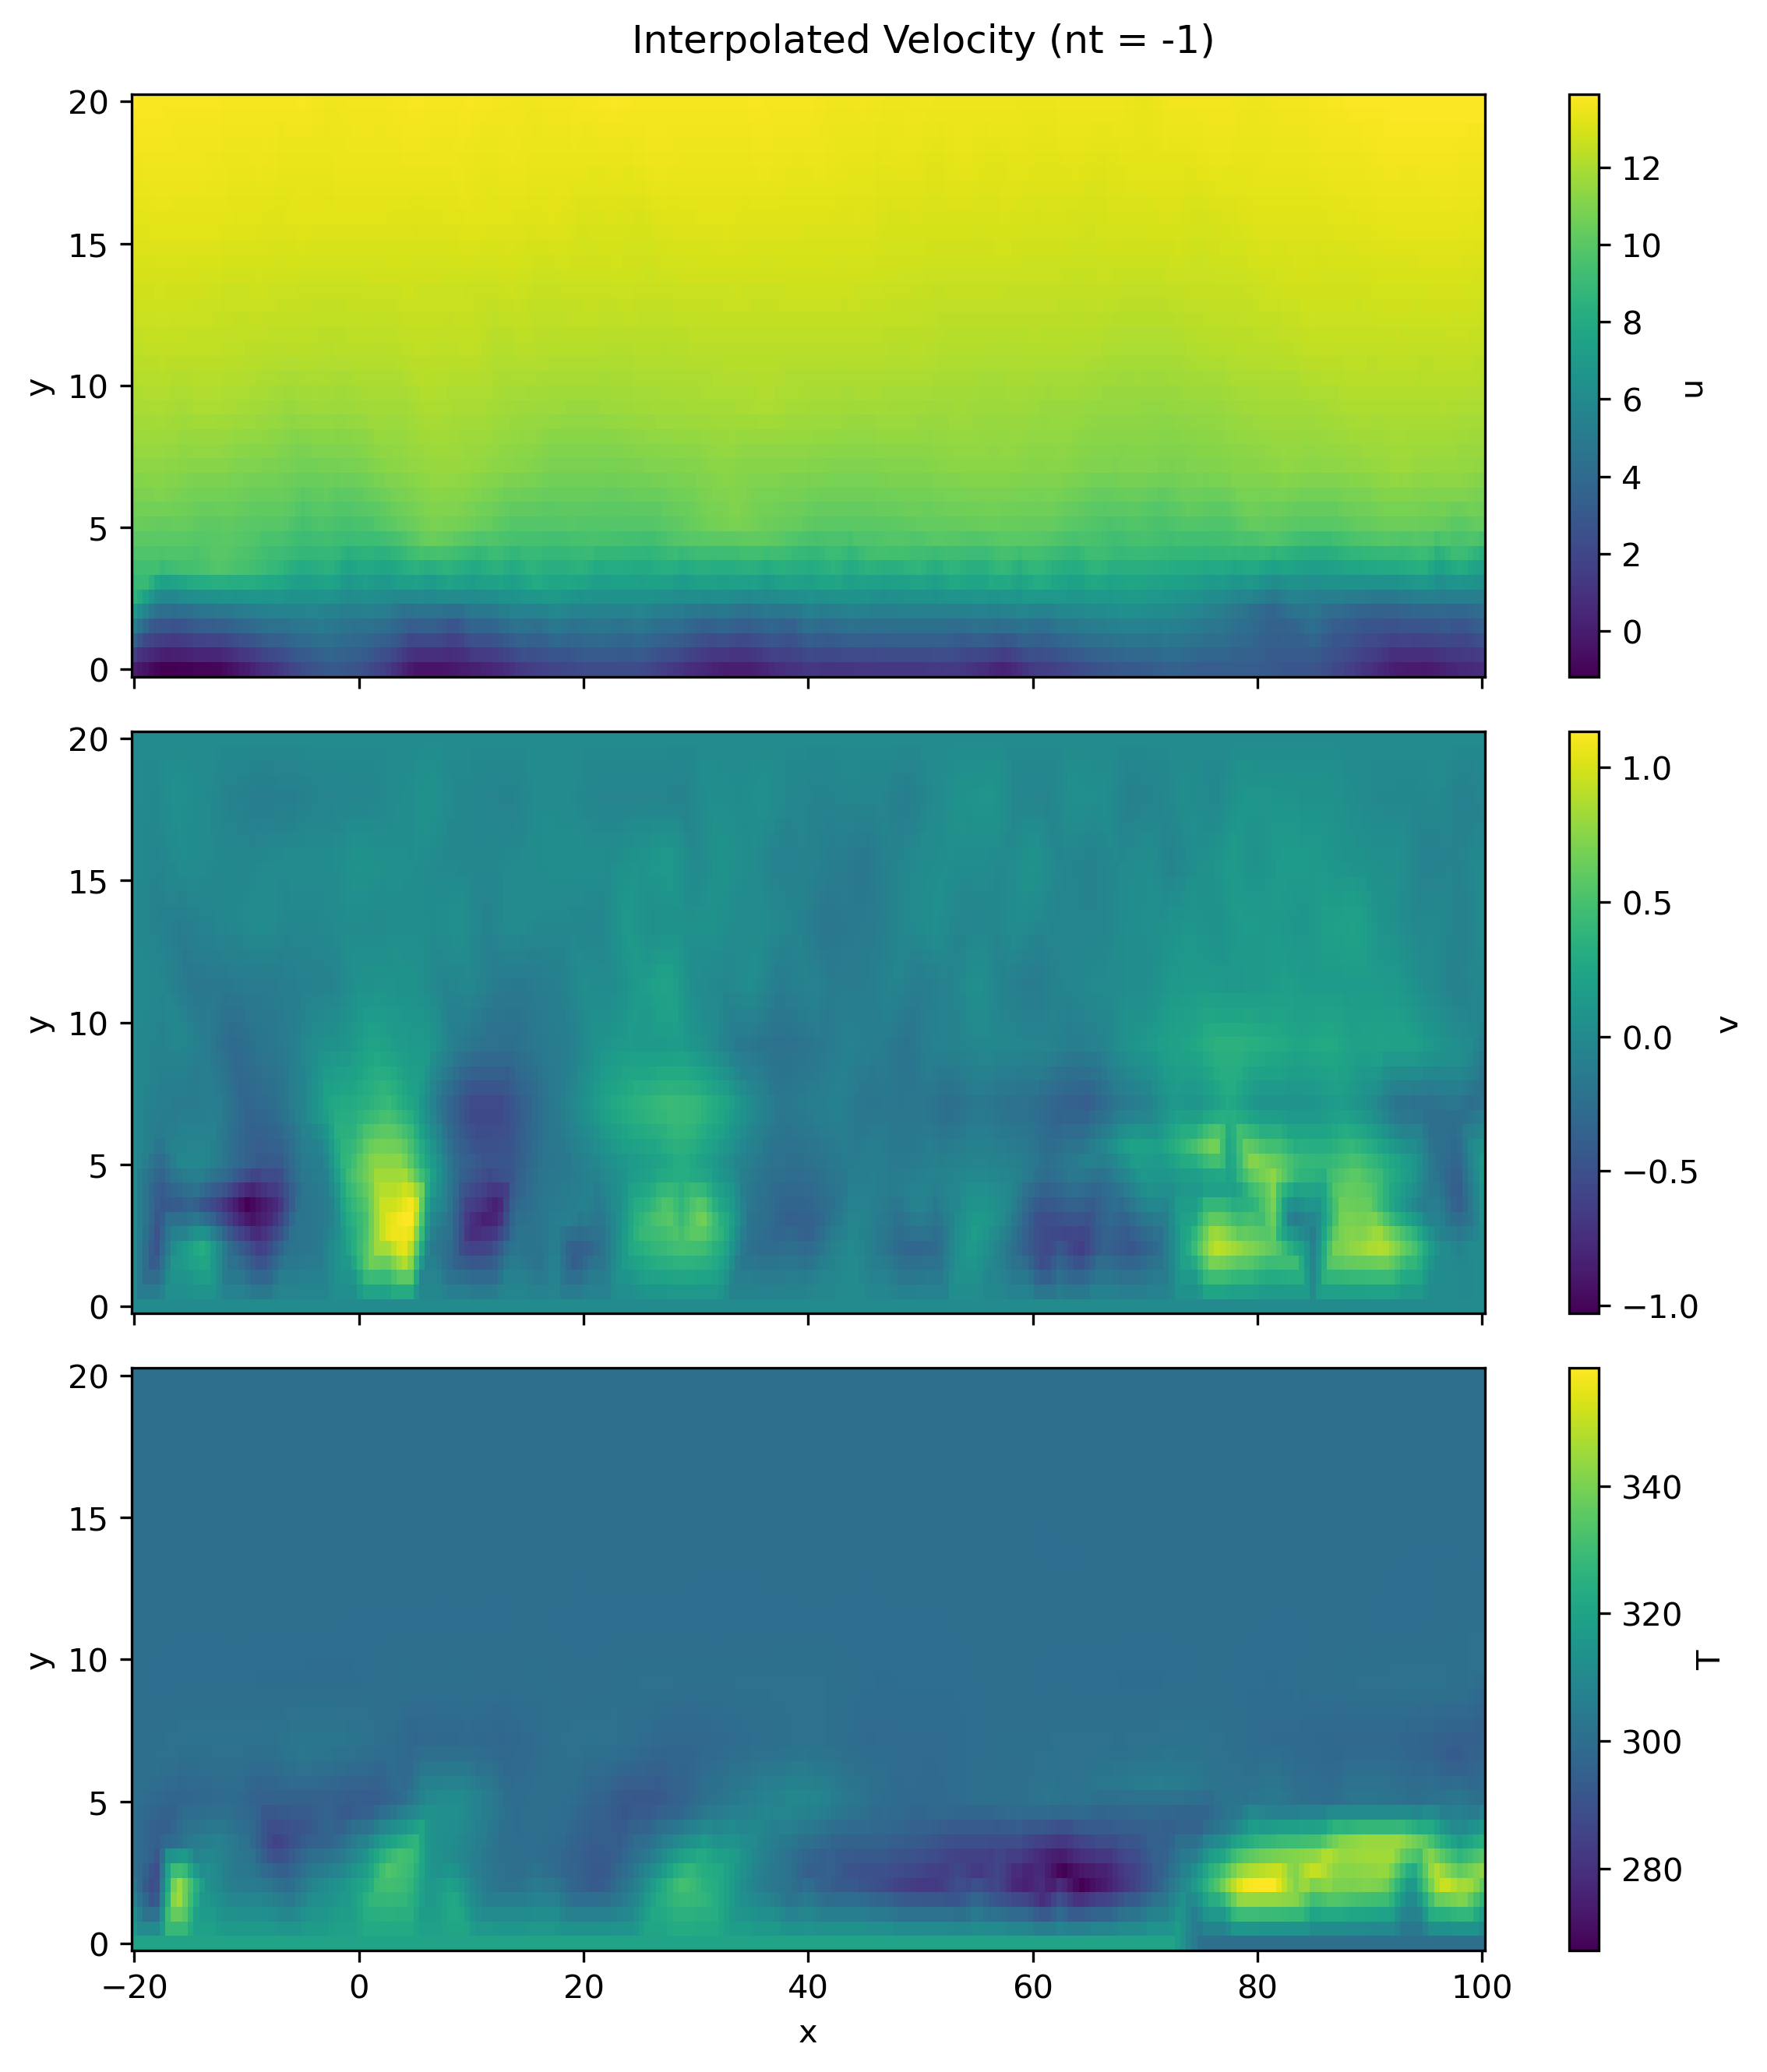

In [7]:
# Plot with pcolormesh or imshow
t = -1 #200

# fig, axs = plt.subplots(2, 1, figsize=[8,6], sharex=True, dpi=300)
fig, axs = plt.subplots(3, 1, figsize=[8,9], sharex=True, dpi=300)

fig.suptitle("Interpolated Velocity (nt = {})".format(t))

for comp,ax in zip(data.keys(), axs.ravel()):
    pcm = ax.pcolormesh(X, Y, data[comp][t, :, :], shading='auto', cmap='viridis')
    plt.colorbar(pcm, ax=ax, label=comp)
    ax.set_ylabel("y")
axs[-1].set_xlabel("x")
plt.tight_layout()

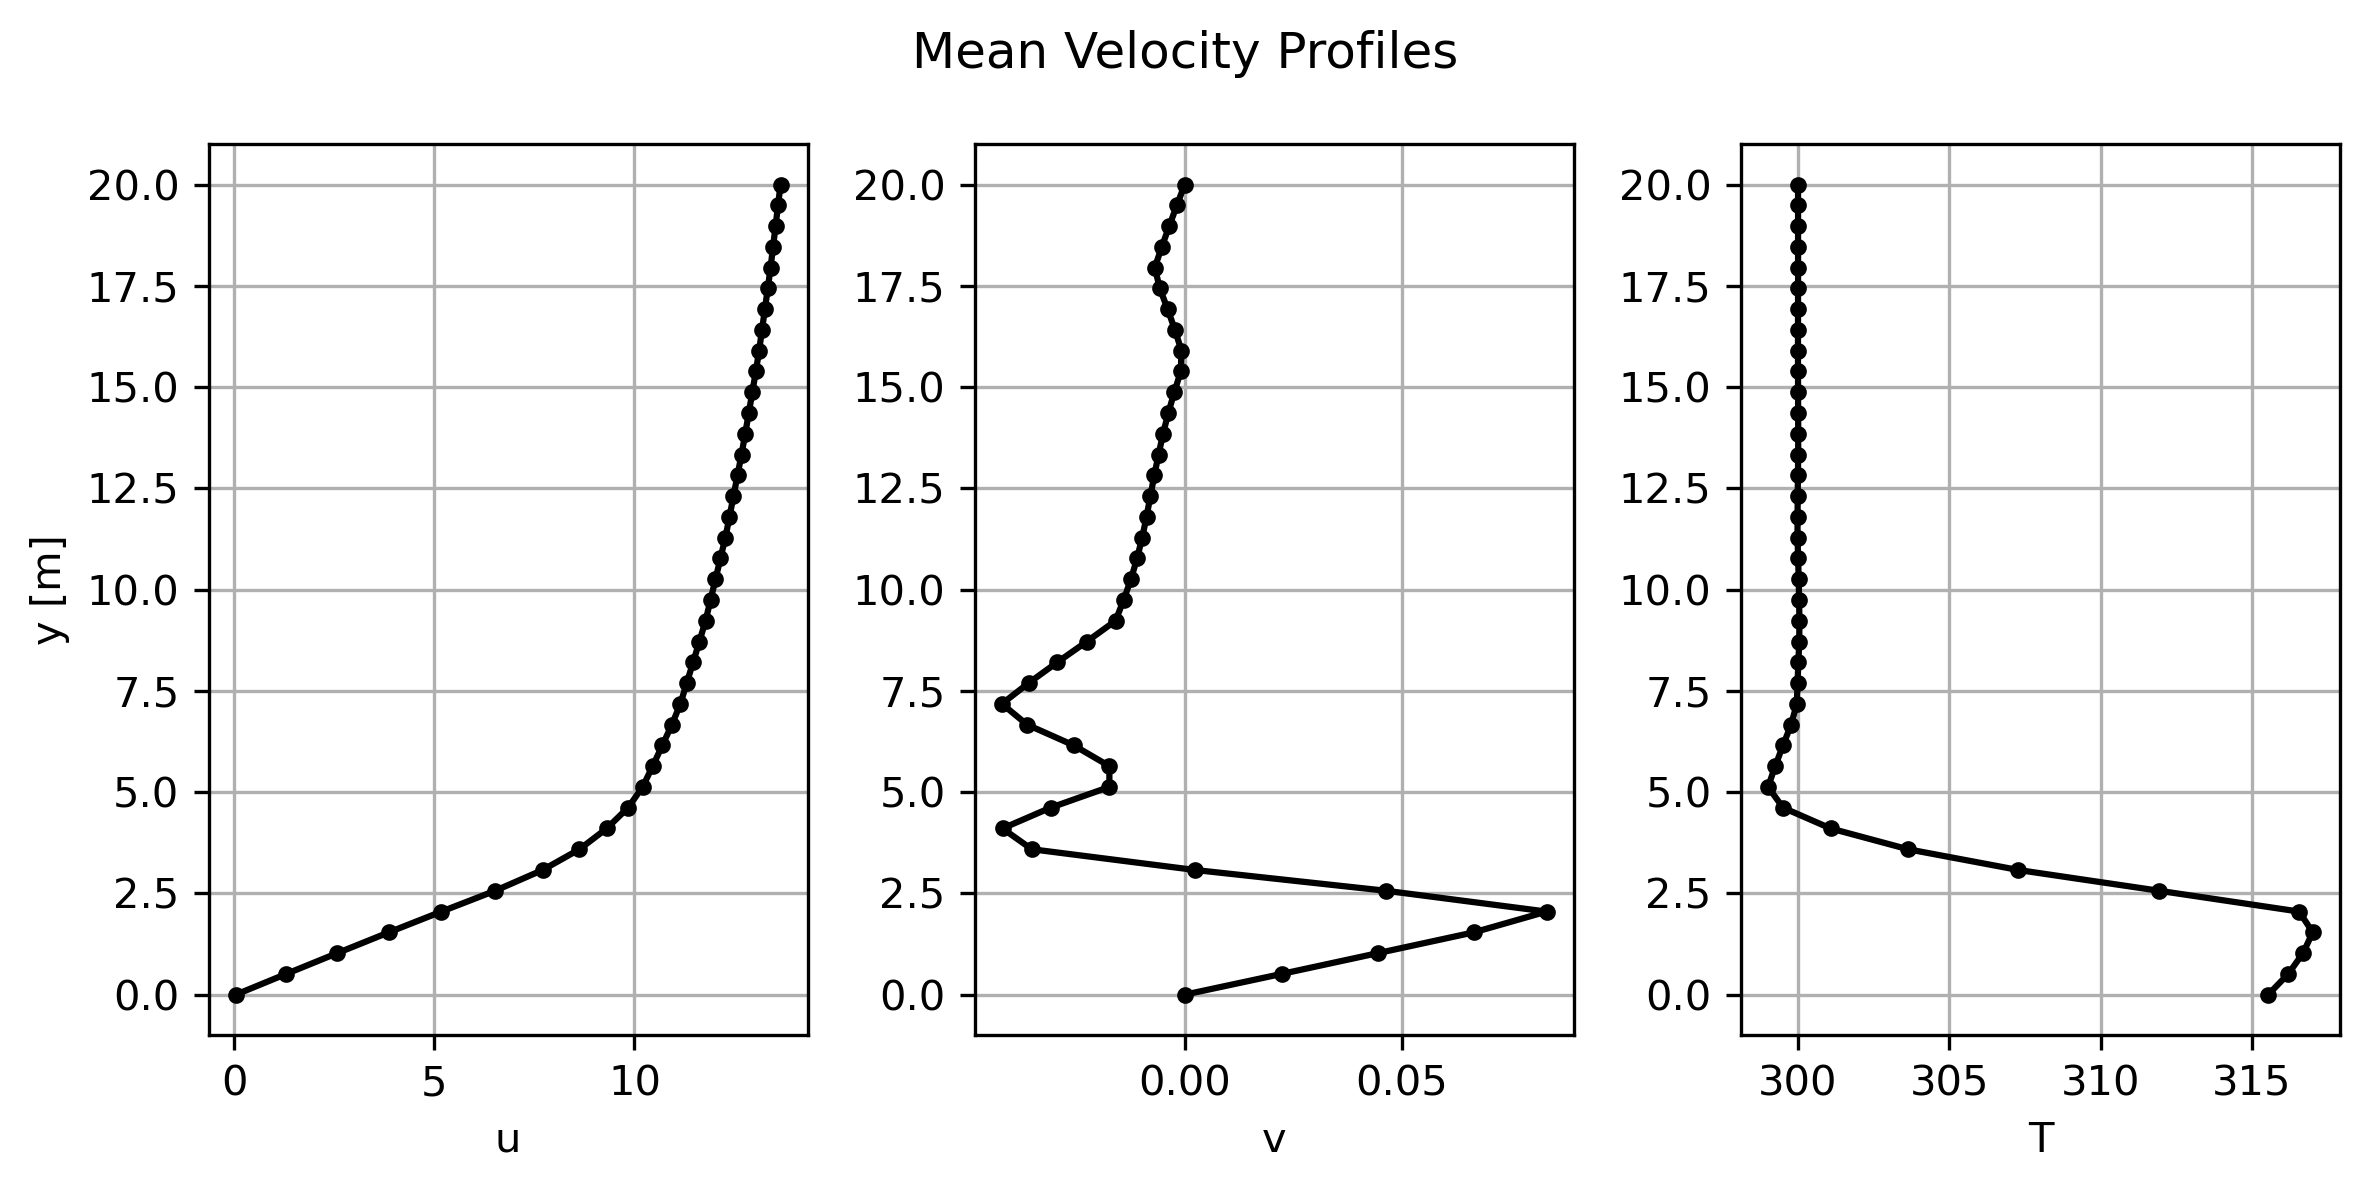

In [9]:
# plot vertical profiles
fig, axs = plt.subplots(1, 3, figsize=[8,4], dpi=300)

fig.suptitle("Mean Velocity Profiles")

for comp,ax in zip(data.keys(), axs.ravel()):
    ax.plot(np.average(np.average(data[comp],axis=0),axis=0), yi, 'k.-')
    ax.set_xlabel("{}".format(comp))
    ax.grid()
axs[0].set_ylabel("y [m]")
plt.tight_layout()

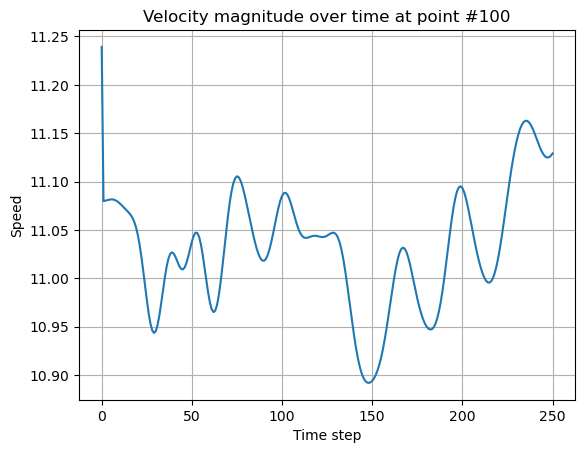

In [10]:
# Compute speed (vector magnitude) at point 100 across time
point_index = 100
speed = np.linalg.norm(data_array[:, point_index, :], axis=1)

plt.plot(speed)
plt.title(f"Velocity magnitude over time at point #{point_index}")
plt.xlabel("Time step")
plt.ylabel("Speed")
plt.grid(True)
plt.show()

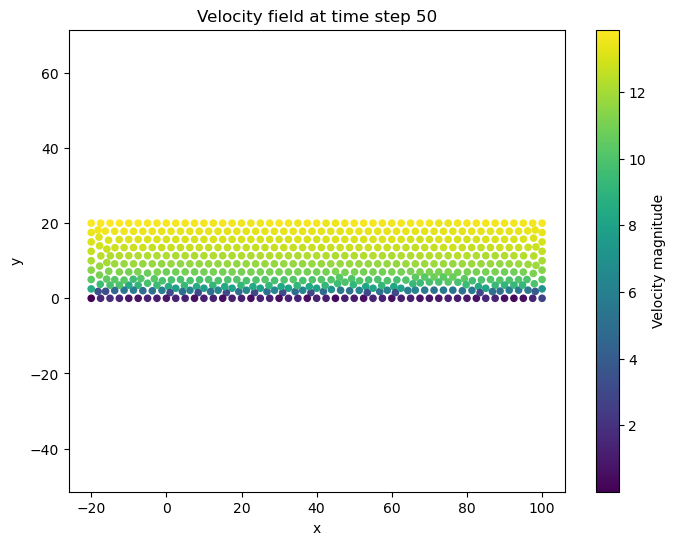

In [11]:
# Use a time step
t = 50
v = data_array[t]
speed = np.linalg.norm(v, axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=speed, cmap="viridis", s=20)
# plt.scatter(coords[:, 0], coords[:, 1], c=v[:,0], cmap="viridis", s=20)
plt.colorbar(label="Velocity magnitude")
plt.title(f"Velocity field at time step {t}")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()